# Телеком — описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.


Описание полей данных:

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – электронный платёжный документ,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Цель
Разработать прототип модели машинного обучения для задачи классификации пользователей:  расторг контракт/не расторг контракт.
Целевая метрика модели ROC-AUC.
Модель должна показать метрику ROC-AUC не хуже чем 0.85 на тестовой выборке.
(RANDOM_STATE = 160123)

# 1. Исследовательский анализ данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostClassifier, Pool, metrics, cv
import lightgbm as lgb

import time
import optuna
import seaborn as sns
import phik
import optuna.integration.lightgbm as lgbopt

Загрузим данные:

In [1]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except FileNotFoundError as e:
    print(repr(e))
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

NameError: name 'pd' is not defined

In [20]:
contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [21]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Столбец TotalCharges необходимо привести к численному типу

In [22]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [23]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [24]:
contract.loc[contract['TotalCharges'].isnull()]

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  
488   Bank transfer (automatic)           52.55           NaN  
753                Mailed check           20.25           NaN  
936                Mailed check           80.85           NaN  
1082               Mailed check           25.75           NaN  
1340    Credit card (automatic)           56.05           NaN  
3331               Mailed check           19.85           NaN  
3826               Mailed check           25.35           NaN  
4380               Mailed check           20.00           NaN  
5218               Mailed check           19.70           NaN  
6670               Mailed check           73.35           NaN  
6754  Bank transfer (automatic)           61.90           NaN

Понятно, оказалось это были неявные пропуски для новых клиентов которые не успели заплатить даже за первый месяц, так как подключились в день снятия данных. Mожем поставить для них 0.

In [25]:
contract['TotalCharges'].fillna(0, inplace=True)

In [26]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Посмотрим графически распределения по категориальным признакам из таблицы contracts

In [27]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate']) # переведем begin date в формат даты

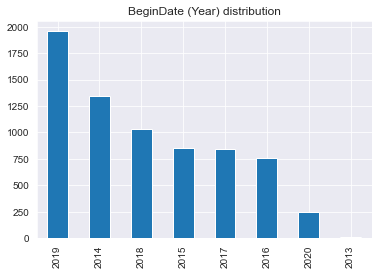

In [28]:
contract['BeginDate'].dt.year.value_counts().plot(kind='bar', title='BeginDate (Year) distribution' )
plt.show()

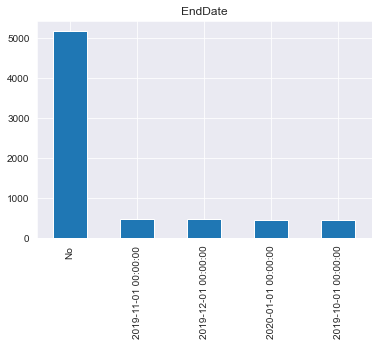

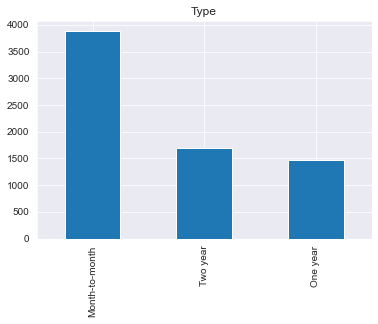

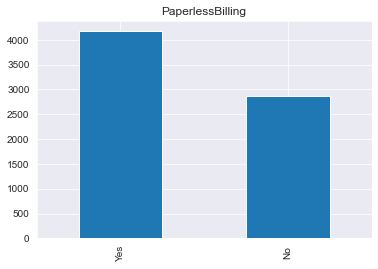

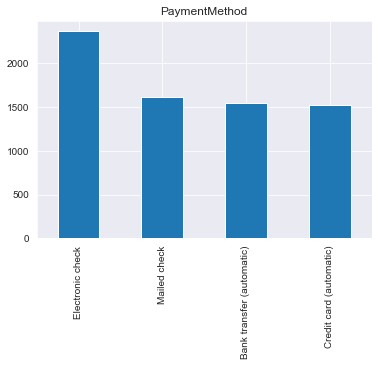

In [29]:
for i in contract.columns[2:-2]:
    contract[i].value_counts().plot(kind='bar', title=i)
    plt.show()

Интересно, что у нас только 4 значения даты в которые разрывался контракт. Это выглядит странно.

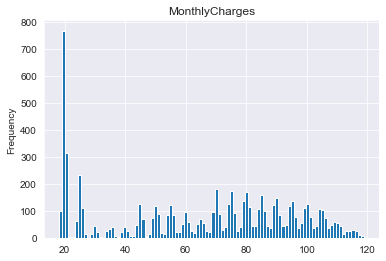

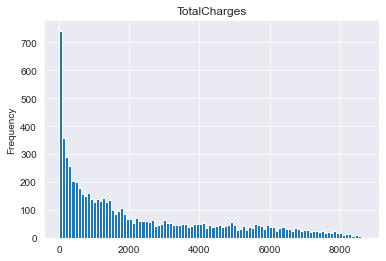

In [30]:
for i in contract.columns[-2:]:
    contract[i].plot(kind='hist', bins=100, title=i)
    plt.show()

Распределения выглядят адекватно. Самое большое количество клиентов на самом дешевом тарифе

In [31]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


In [32]:
contract.describe()

MonthlyCharges  TotalCharges
count     7043.000000   7043.000000
mean        64.761692   2279.734304
std         30.090047   2266.794470
min         18.250000      0.000000
25%         35.500000    398.550000
50%         70.350000   1394.550000
75%         89.850000   3786.600000
max        118.750000   8684.800000

In [33]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [34]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


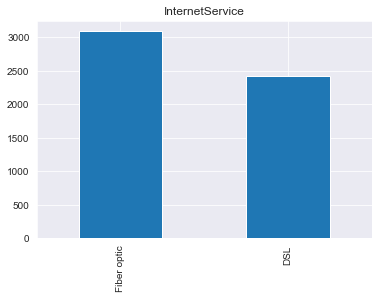

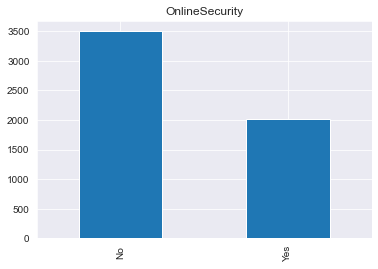

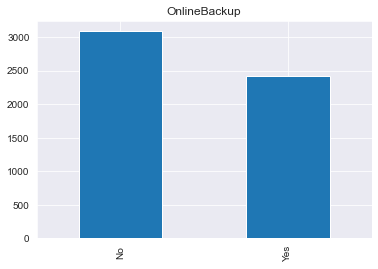

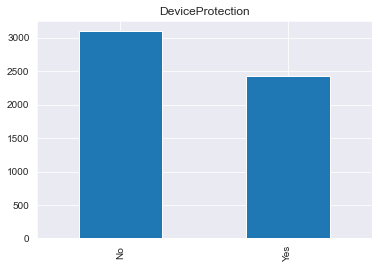

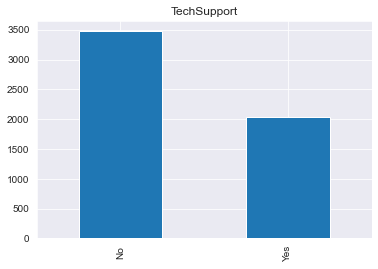

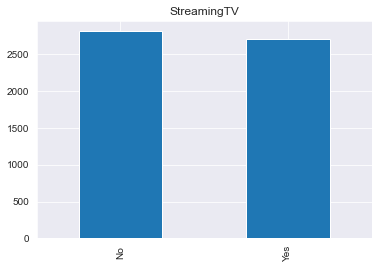

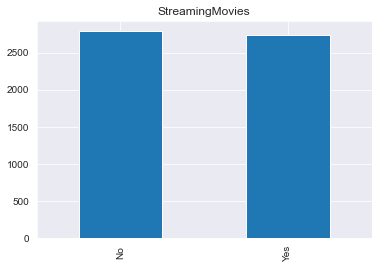

In [35]:
for i in internet.columns[1:]:

    internet[i].value_counts().plot(kind='bar', title=i)
    plt.show()


In [36]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [37]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


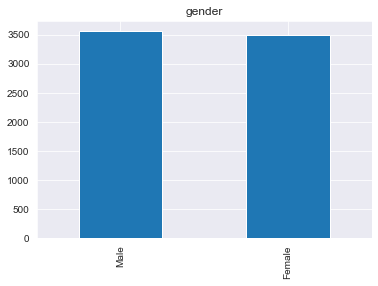

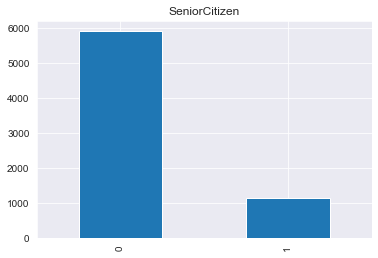

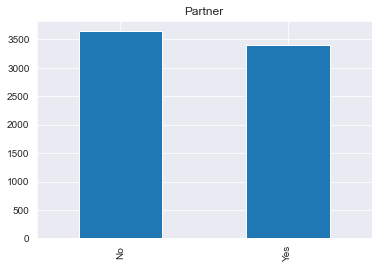

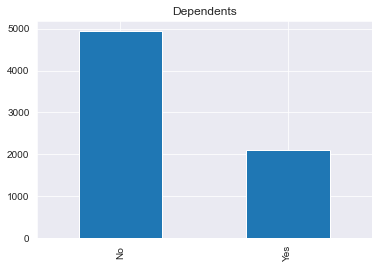

In [38]:
for i in personal.columns[1:]:
    personal[i].value_counts().plot(kind='bar', title=i)
    plt.show()

Преобразуем Senior_Citizen в object чтобы далее работать с этим столбцом как с другими категориальными переменными

In [39]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace([0,1],['No','Yes'])

In [40]:
personal['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

Все в порядке, распределения адекватные, лишних значений нет

In [41]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

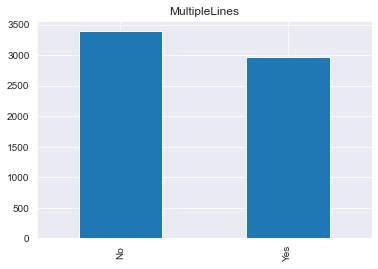

In [42]:
phone['MultipleLines'].value_counts().plot(kind='bar', title='MultipleLines')
plt.show()

In [43]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Посмотрим сколько у нас разторгнувших контракт клиентов

In [44]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [45]:
c_ended_qty = contract.shape[0] - contract.loc[contract['EndDate'] == 'No','EndDate'].value_counts()[0]
c_ended_perc = round(((c_ended_qty / contract.shape[0])),2)

print("Количество расторгнувших", c_ended_qty)
print("Доля расторгнувших контракт", c_ended_perc)

Количество расторгнувших 1869
Доля расторгнувших контракт 0.27


Примерно четверть клиентов из наших данных разорвали контракт. Наличие даты в столбце "End Date" говорит о том что клиент ушел, соответственно далее мы создадим целевой признак с классами "ушел,не ушел".

In [46]:
contract['class'] = contract['EndDate'] != 'No'

In [47]:
contract.head()

customerID  BeginDate              EndDate            Type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

   class  
0  False  
1  False  
2   True  
3  False  
4   True

Заменим поля 'No' EndDate на 2020-02-01 (1 февраля, дату на которую данные о контрактах валидны) с целью потом рассчитать длительность контракта каждого клиента на текущую дату

In [48]:
contract['EndDate'].replace('No', '2020-02-01', inplace=True)
contract.head()

customerID  BeginDate              EndDate            Type  \
0  7590-VHVEG 2020-01-01           2020-02-01  Month-to-month   
1  5575-GNVDE 2017-04-01           2020-02-01        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01           2020-02-01        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

   class  
0  False  
1  False  
2   True  
3  False  
4   True

Приведем дату к типу datatime

In [49]:

contract['EndDate'] = pd.to_datetime(contract['EndDate'],format="%Y-%m-%d")

In [50]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   class             7043 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(2), object(4)
memory usage: 447.2+ KB


In [51]:
contract.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  class  
0           Electronic check           29.85         29.85  False  
1               Mailed check           56.95       1889.50  False  
2               Mailed check           53.85        108.15   True  
3  Bank transfer (automatic)           42.30       1840.75  False  
4           Electronic check           70.70        151.65   True

Посчитаем длительность контракта на момент снятия данных

In [52]:
contract['duration'] = contract['EndDate'] - contract['BeginDate']
contract['duration_days'] = contract['duration'].dt.days

In [53]:
contract.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  class  duration  \
0           Electronic check           29.85         29.85  False   31 days   
1               Mailed check           56.95       1889.50  False 1036 days   
2               Mailed check           53.85        108.15   True   61 days   
3  Bank transfer (automatic)           42.30       1840.75  False 1371 days   
4           Electronic check           70.70        151.65   True   61 days   

   duration_days  
0             31  
1           1036  
2             61  
3           1371  
4             61

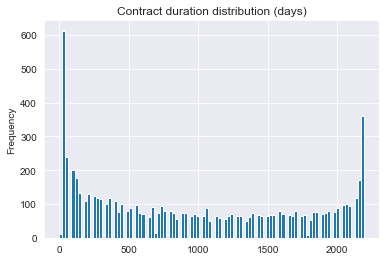

In [54]:
contract['duration_days'].plot(kind='hist', bins=100, title='Contract duration distribution (days)')
plt.show()

Интересное распределение: есть два всплеска самых "новых" клиентов и самых "старых" клиентов.
При этом распределение по остальным вариантам продолжительности контрактов практически равномерное.

In [55]:
contract['duration_days'].describe()

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: duration_days, dtype: float64

Объединим таблицы в одну. Будем "джоинить" таблицы используя ID клиента, за основную таблицу возьмем контракты

In [56]:
df = pd.merge(contract, personal, how='left', on='customerID')

In [57]:
df = pd.merge(df, internet, how='left', on='customerID')

In [58]:
df = pd.merge(df, phone, how='left', on='customerID')

In [59]:
df.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  class  duration  \
0           Electronic check           29.85         29.85  False   31 days   
1               Mailed check           56.95       1889.50  False 1036 days   
2               Mailed check           53.85        108.15   True   61 days   
3  Bank transfer (automatic)           42.30       1840.75  False 1371 days   
4           Electronic check           70.70        151.65   True   61 days   

   ...  Partner Dependents InternetService OnlineSecurity OnlineBackup  \
0  ...      Yes         No             DSL             No          Yes   
1  ...       No         No             DSL            Yes           No   
2  ...       No         No             DSL            Yes          Yes   
3  ...       No         No             DSL            Yes           No   
4  ...       No         No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies MultipleLines  
0               No          No          No              No           NaN  
1              Yes          No          No              No            No  
2               No          No          No              No            No  
3              Yes         Yes          No              No           NaN  
4               No          No          No              No            No  

[5 rows x 23 columns]

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerID        7043 non-null   object         
 1   BeginDate         7043 non-null   datetime64[ns] 
 2   EndDate           7043 non-null   datetime64[ns] 
 3   Type              7043 non-null   object         
 4   PaperlessBilling  7043 non-null   object         
 5   PaymentMethod     7043 non-null   object         
 6   MonthlyCharges    7043 non-null   float64        
 7   TotalCharges      7043 non-null   float64        
 8   class             7043 non-null   bool           
 9   duration          7043 non-null   timedelta64[ns]
 10  duration_days     7043 non-null   int64          
 11  gender            7043 non-null   object         
 12  SeniorCitizen     7043 non-null   object         
 13  Partner           7043 non-null   object         
 14  Dependen

Посмотрим распределение клиентов по услугам. Для этого создадим новый столбец тип сервиса

In [61]:
def service(row):
    if row['InternetService'] == row['InternetService'] and row['MultipleLines'] != row['MultipleLines']:
        return 'Internet'
    if row['InternetService'] == row['InternetService'] and row['MultipleLines'] == row['MultipleLines']:
        return 'Internet+Phone'
    if row['InternetService'] != row['InternetService'] and row['MultipleLines'] == row['MultipleLines']:
        return 'Phone'

In [62]:
df['service']=df.apply(service, axis=1)

In [63]:
df.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  class  duration  \
0           Electronic check           29.85         29.85  False   31 days   
1               Mailed check           56.95       1889.50  False 1036 days   
2               Mailed check           53.85        108.15   True   61 days   
3  Bank transfer (automatic)           42.30       1840.75  False 1371 days   
4           Electronic check           70.70        151.65   True   61 days   

   ...  Dependents InternetService OnlineSecurity OnlineBackup  \
0  ...          No             DSL             No          Yes   
1  ...          No             DSL            Yes           No   
2  ...          No             DSL            Yes          Yes   
3  ...          No             DSL            Yes           No   
4  ...          No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies MultipleLines  \
0               No          No          No              No           NaN   
1              Yes          No          No              No            No   
2               No          No          No              No            No   
3              Yes         Yes          No              No           NaN   
4               No          No          No              No            No   

          service  
0        Internet  
1  Internet+Phone  
2  Internet+Phone  
3        Internet  
4  Internet+Phone  

[5 rows x 24 columns]

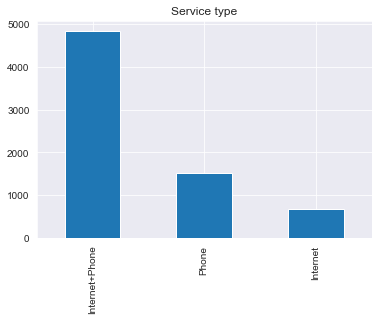

In [64]:
df['service'].value_counts().plot(kind='bar', title='Service type')
plt.show()

Большинство клиентов используют обе услуги. При этом тех кто используют только интернет в два раза меньше чем тех кто использует только телефонную связь.

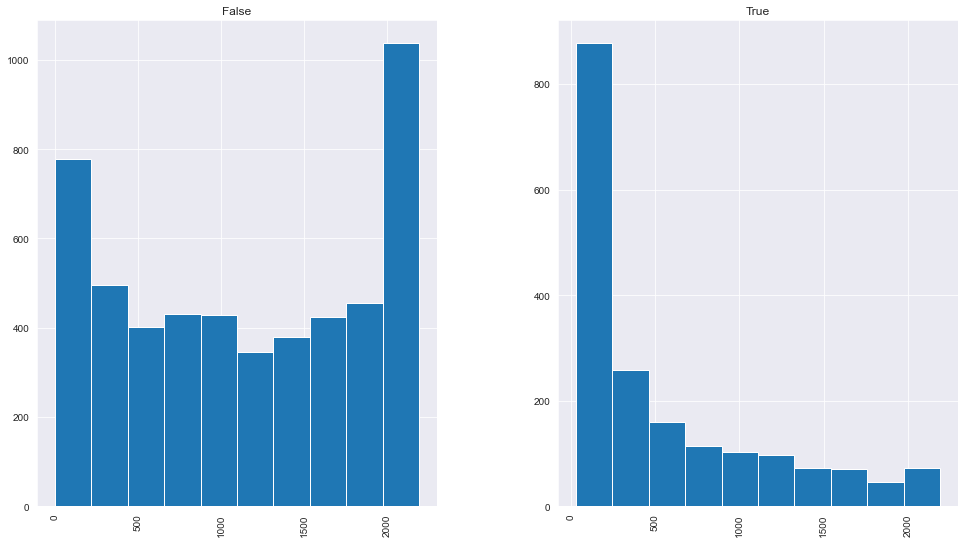

In [65]:
df.hist(column='duration_days',by='class',figsize=(16,9))
plt.show()

Получается, что большинство клиентов расторгнувшие пользовались услугами провайдера меньше года.

In [66]:
df.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  class  duration  \
0           Electronic check           29.85         29.85  False   31 days   
1               Mailed check           56.95       1889.50  False 1036 days   
2               Mailed check           53.85        108.15   True   61 days   
3  Bank transfer (automatic)           42.30       1840.75  False 1371 days   
4           Electronic check           70.70        151.65   True   61 days   

   ...  Dependents InternetService OnlineSecurity OnlineBackup  \
0  ...          No             DSL             No          Yes   
1  ...          No             DSL            Yes           No   
2  ...          No             DSL            Yes          Yes   
3  ...          No             DSL            Yes           No   
4  ...          No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies MultipleLines  \
0               No          No          No              No           NaN   
1              Yes          No          No              No            No   
2               No          No          No              No            No   
3              Yes         Yes          No              No           NaN   
4               No          No          No              No            No   

          service  
0        Internet  
1  Internet+Phone  
2  Internet+Phone  
3        Internet  
4  Internet+Phone  

[5 rows x 24 columns]

Уберем из таблицы признак customerID, идентификатор не может быть категориальным признаком для нашей задачи.

Также надо убрать BeginDate и EndDate, вместо этого оставим созданный признак Duration_days (duration удалим).
EndDate несет утечку целевого признака. (А если оставить BeginDate и Duration, также будет утечка целевого признака)

In [67]:
df.drop(['customerID','BeginDate','EndDate','duration'], axis=1, inplace=True)

Построим матрицу коэффецентов корреляции Phik

In [68]:
corr_matrix = df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'duration_days']


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

Для анализа матрицы коэффициентов корреляции между признаками воспользуемся диаграммой hitmap

In [69]:
sns.set(rc={'figure.figsize': (14, 10)})

<AxesSubplot:>

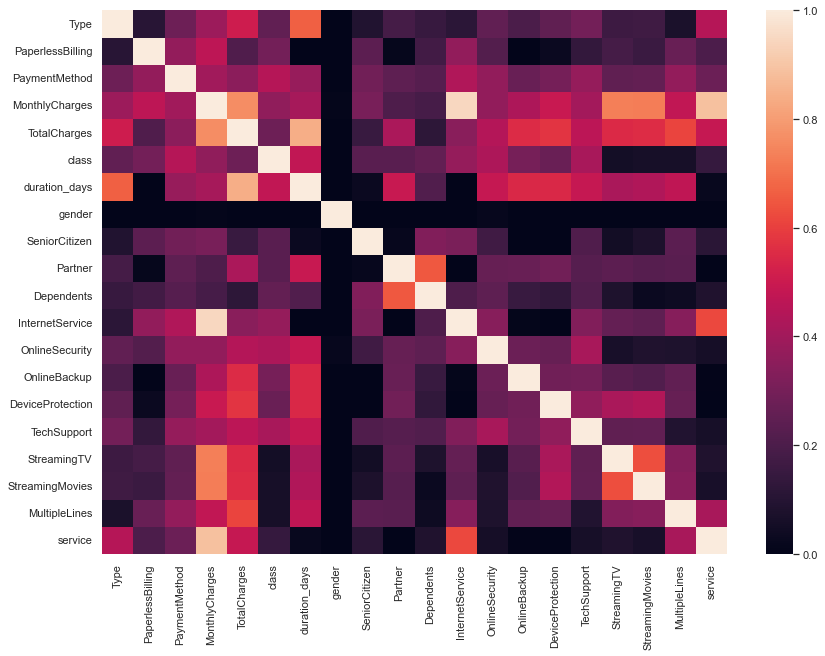

In [70]:
sns.heatmap(corr_matrix)

Наибольшую корреляцию имеют следующие признаки:
1. Monthly Charges vs Total Charges это вполне объяснимо
2. Duration Days vs Total Charges логично, больше продолжительность контракта - больше абонент заплатил
3. Monthly Charges vs (InternetService,StreamingTv,StreamingMovies). Очевидно что абоненты с этими услугами платят больше чем клиенты без них
4. Dependents vs Partner. Логично что абоненты имеющие партнера вероятнее имеют иждивенцев чем одинокие клиенты.
5. StreamingTV vs StreamingMovies. Логично что признаки связано StreamingMovies вряд ли будет подключена без услуги StreamingTV.
6. Type vs Duration Days. Да видимо система оплаты связана продолжительностью контракта. Что вполне объяснимо: у тех у кого годовой контракт скорее всего большая продолжительность контракта чем те кто сидят на подписке.

Наибольшая связь целевого признака имеется со следующими признаками:
1. Payment Method
2. Duration Days
3. Online Security
4. Tech Support

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> Добавил. Вопрос на будущее можно ли как то результаты корр. анализа использовать с пользой при обучении моделей, например признакам имеющим большую связь с целевым присваивать большие веса?</div>

# 2 Предобработка и подготовка данных

В данном разделе обработаю данные, удалю пропуски, закодирую категориальные переменные для моделей которые в явном виде не умеют работать с кат. признаками.

Разобью данные на обучающую и тестовую выборку

In [71]:
df.head()

Type PaperlessBilling              PaymentMethod  MonthlyCharges  \
0  Month-to-month              Yes           Electronic check           29.85   
1        One year               No               Mailed check           56.95   
2  Month-to-month              Yes               Mailed check           53.85   
3        One year               No  Bank transfer (automatic)           42.30   
4  Month-to-month              Yes           Electronic check           70.70   

   TotalCharges  class  duration_days  gender SeniorCitizen Partner  \
0         29.85  False             31  Female            No     Yes   
1       1889.50  False           1036    Male            No      No   
2        108.15   True             61    Male            No      No   
3       1840.75  False           1371    Male            No      No   
4        151.65   True             61  Female            No      No   

  Dependents InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0         No             DSL             No          Yes               No   
1         No             DSL            Yes           No              Yes   
2         No             DSL            Yes          Yes               No   
3         No             DSL            Yes           No              Yes   
4         No     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies MultipleLines         service  
0          No          No              No           NaN        Internet  
1          No          No              No            No  Internet+Phone  
2          No          No              No            No  Internet+Phone  
3         Yes          No              No           NaN        Internet  
4          No          No              No            No  Internet+Phone

Уберем из таблицы признак customerID, идентификатор не может быть категориальным признаком для нашей задачи.

Также надо убрать BeginDate и EndDate, вместо этого оставим созданный признак Duration_days (duration удалим).
EndDate несет утечку целевого признака. (А если оставить BeginDate и Duration, также будет утечка целевого признака)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   class             7043 non-null   bool   
 6   duration_days     7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   object 
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null   object 


Поставим заглушки на пропуски в столбцах из таблиц Internet и Phone

In [73]:
df.fillna('NA', inplace=True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   class             7043 non-null   bool   
 6   duration_days     7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   object 
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


Разобьем выборку на train и test

In [75]:
train, test = train_test_split(df,test_size=0.25, random_state=160123)

In [76]:
x_train = train.drop('class', axis=1)
y_train = train['class']

x_test = test.drop('class', axis=1)
y_test = test['class']

In [77]:
x_train.shape

(5282, 19)

In [78]:
x_test.shape

(1761, 19)

In [79]:
y_train.shape

(5282,)

In [80]:
y_test.shape

(1761,)

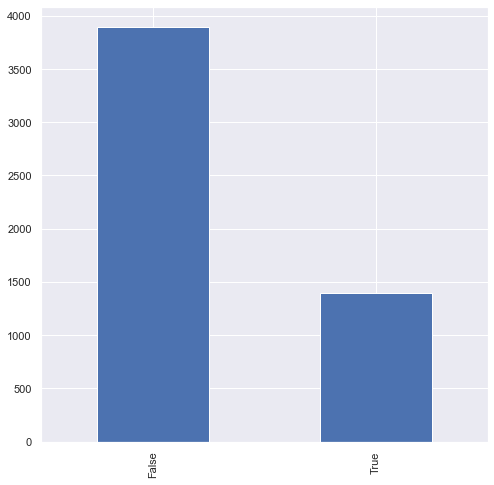

In [81]:
y_train.value_counts().plot(kind='bar', figsize=(8,8))
plt.show()

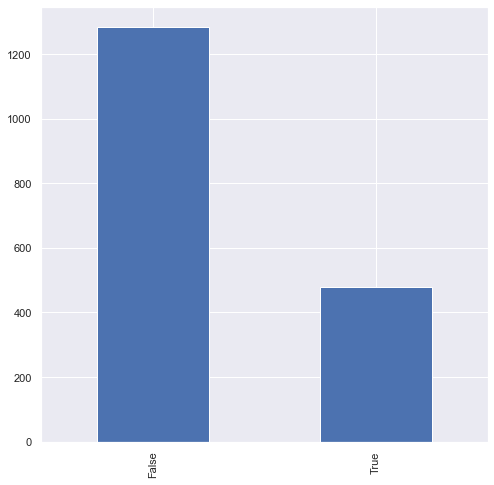

In [82]:
y_test.value_counts().plot(kind='bar',  figsize=(8,8))
plt.show()

Выборки разбиты верно количественно, соотношение классов примерно одинаковое в обоих выборках.

Сделаем трансформеры для преобразования категориальных переменных

1. OHE для категориальных переменных

In [83]:
ohe_sc_transform= make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(
        sparse_output=True,
        handle_unknown='ignore',
        drop="first"
    ),
     make_column_selector(dtype_include=object)))

In [84]:
x_train_ohe_sc = ohe_sc_transform.fit_transform(x_train)

In [85]:
x_test_ohe_sc = ohe_sc_transform.transform(x_test)

In [86]:
x_train_ohe_sc[0:5]

array([[-0.51077135, -0.87876448, -1.03817632,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.17064141, -0.60296293, -0.79639346,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ],
       [-1.5046368 , -0.43566299,  1.15523506,  0.        ,  1.        ,
       

2. OrdinalEncoder для категориальных переменных

In [87]:
ord_sc_transform= make_column_transformer(
                                            (StandardScaler(), make_column_selector(dtype_include=np.number)),
                                            (OrdinalEncoder(handle_unknown='error'),
                                             make_column_selector(dtype_include=object))
                                          )

In [88]:
x_train_ord_sc = ord_sc_transform.fit_transform(x_train)

In [89]:
x_test_ord_sc = ord_sc_transform.transform(x_test)

In [90]:
x_train_ord_sc[0:5]

array([[-0.51077135, -0.87876448, -1.03817632,  2.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  2.        ,  1.        ,  2.        ,  2.        ,
         1.        ,  2.        ,  0.        ,  0.        ],
       [ 0.17064141, -0.60296293, -0.79639346,  0.        ,  1.        ,
         2.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ],
       [-1.5046368 , -0.43566299,  1.15523506,  2.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         2.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  2.        ],
       [ 0.97337889,  0.72777296,  0.4245432 ,  0.        ,  1.        ,
         2.        ,  1.        ,  1.        ,  1.        ,  0.        ,
         1.   

Сохраним названия фич

In [91]:
ord_f_name = ord_sc_transform.get_feature_names_out()
ohe_f_name = ohe_sc_transform.get_feature_names_out()

In [92]:
ord_f_name

array(['standardscaler__MonthlyCharges', 'standardscaler__TotalCharges',
       'standardscaler__duration_days', 'ordinalencoder__Type',
       'ordinalencoder__PaperlessBilling',
       'ordinalencoder__PaymentMethod', 'ordinalencoder__gender',
       'ordinalencoder__SeniorCitizen', 'ordinalencoder__Partner',
       'ordinalencoder__Dependents', 'ordinalencoder__InternetService',
       'ordinalencoder__OnlineSecurity', 'ordinalencoder__OnlineBackup',
       'ordinalencoder__DeviceProtection', 'ordinalencoder__TechSupport',
       'ordinalencoder__StreamingTV', 'ordinalencoder__StreamingMovies',
       'ordinalencoder__MultipleLines', 'ordinalencoder__service'],
      dtype=object)

In [93]:
ohe_f_name

array(['standardscaler__MonthlyCharges', 'standardscaler__TotalCharges',
       'standardscaler__duration_days', 'onehotencoder__Type_One year',
       'onehotencoder__Type_Two year',
       'onehotencoder__PaperlessBilling_Yes',
       'onehotencoder__PaymentMethod_Credit card (automatic)',
       'onehotencoder__PaymentMethod_Electronic check',
       'onehotencoder__PaymentMethod_Mailed check',
       'onehotencoder__gender_Male', 'onehotencoder__SeniorCitizen_Yes',
       'onehotencoder__Partner_Yes', 'onehotencoder__Dependents_Yes',
       'onehotencoder__InternetService_Fiber optic',
       'onehotencoder__InternetService_NA',
       'onehotencoder__OnlineSecurity_No',
       'onehotencoder__OnlineSecurity_Yes',
       'onehotencoder__OnlineBackup_No',
       'onehotencoder__OnlineBackup_Yes',
       'onehotencoder__DeviceProtection_No',
       'onehotencoder__DeviceProtection_Yes',
       'onehotencoder__TechSupport_No', 'onehotencoder__TechSupport_Yes',
       'onehotencoder__S

# 3. Обучение и анализ моделей

## 3.1 Log Regression

 Создадим сетку параметров Log Regression для Grid Search

In [79]:
params_lg = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear','saga','sag'],
    'penalty' : ['l2', 'none','l1'],
    'C' :  [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [100,200,500],
    'n_jobs': [-1]
}

In [80]:
model_lg = LogisticRegression()

Иниицируем GridSearchCv

In [81]:
lg_gscv = GridSearchCV(model_lg,params_lg,scoring='roc_auc',n_jobs=-1,verbose=2)

In [82]:
lg_gscv.fit(x_train_ohe_sc,y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. G

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'max_iter': [100, 200, 500], 'n_jobs': [-1],
                         'penalty': ['l2', 'none', 'l1'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga',
                                    'sag']},
             scoring='roc_auc', verbose=2)

Полученная метрика roc_auc на кросс-валидации

In [83]:
lg_gscv.best_score_

0.8432233071300619

Наилучшие параметры Логистической регрессии

In [84]:
lg_gscv.best_params_

{'C': 10,
 'max_iter': 100,
 'n_jobs': -1,
 'penalty': 'l1',
 'solver': 'liblinear'}

Логистическая регрессия не позволила получить целевую метрику roc_auc на кросс-валидации выше чем 0.85.
Будем пробовать другие модели

## 3.2 Random Forest Classifier

Сформируем сетку параметров для RF и запустим GridSearchCV

In [85]:

model_rf=RandomForestClassifier(random_state=160123, n_jobs=-1)
params_rf = { 'n_estimators': range(40,200,10),
         'min_samples_leaf': [1, 2, 4, 5],
         'min_samples_split': [2, 8, 10, 12],
         'max_depth': range(1,20,2) },

grid = GridSearchCV(model_rf, params_rf, scoring='roc_auc', n_jobs=-1,verbose=5)

grid.fit(x_train_ord_sc, y_train)



Fitting 5 folds for each of 2560 candidates, totalling 12800 fits
[CV] END C=100, max_iter=100, n_jobs=-1, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=100, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=100, max_iter=100, n_jobs=-1, penalty=l2, solver=sag; total time=   0.1s
[CV] END C=100, max_iter=100, n_jobs=-1, penalty=l1, solver=saga; total time=   0.1s
[CV] END C=100, max_iter=100, n_jobs=-1, penalty=l1, solver=saga; total time=   0.1s
[CV] END C=100, max_iter=100, n_jobs=-1, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=100, max_iter=100, n_jobs=-1, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=100, max_iter=200, n_jobs=-1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, max_iter=200, n_jobs=-1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, max_iter=200, n_jobs=-1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=100, max_iter=200, n_jobs=-1, penalty=l1, solver=lbfgs; total tim

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=160123),
             n_jobs=-1,
             param_grid=({'max_depth': range(1, 20, 2),
                          'min_samples_leaf': [1, 2, 4, 5],
                          'min_samples_split': [2, 8, 10, 12],
                          'n_estimators': range(40, 200, 10)},),
             scoring='roc_auc', verbose=5)

Наилучшие параметры RF полученные GridSearch

In [86]:
grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 170}

Полученная метрика roc_auc на кросс-валидации

In [87]:
grid.best_score_

0.8587602342080405

В целом это соответствует требованию по целевой метрике, но будем пробовать более продвинутые модели

Посмотрим наиболее важные признаки модели RF

In [88]:
feature_importances = grid.best_estimator_.feature_importances_

In [89]:
feature_is = pd.DataFrame({'feature':ord_f_name,'importance':feature_importances})

In [90]:
feature_is.sort_values(by='importance', ascending=False)

feature  importance
2      standardscaler__duration_days    0.246228
3               ordinalencoder__Type    0.157333
1       standardscaler__TotalCharges    0.146744
0     standardscaler__MonthlyCharges    0.110469
10   ordinalencoder__InternetService    0.055482
11    ordinalencoder__OnlineSecurity    0.040843
14       ordinalencoder__TechSupport    0.039464
5      ordinalencoder__PaymentMethod    0.032667
12      ordinalencoder__OnlineBackup    0.026640
15       ordinalencoder__StreamingTV    0.021695
13  ordinalencoder__DeviceProtection    0.019487
16   ordinalencoder__StreamingMovies    0.018521
18           ordinalencoder__service    0.016197
4   ordinalencoder__PaperlessBilling    0.014707
7      ordinalencoder__SeniorCitizen    0.013874
17     ordinalencoder__MultipleLines    0.013366
9         ordinalencoder__Dependents    0.009664
8            ordinalencoder__Partner    0.008580
6             ordinalencoder__gender    0.008040

Наиболее значимыми признаками оказалась длительность контракта, тип оплаты, сумма выплат и ежемесячный платеж

## 3.3 Catboost

Catboost нативно работает с категориальными признакими, но их необходимо в явном виде указать:

In [91]:
x_cat_col = x_train.columns.to_list()

In [92]:
x_cat_col

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'duration_days',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'service']

In [93]:
del x_cat_col[3:6]

In [94]:
x_cat_col

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'service']

Посмотрим какую метрику покажет модель с дефолтными параметрами

Сформируем базовые параметры параметры

In [95]:
pars_def = {"random_seed":160123,
            "early_stopping_rounds":20,
            "loss_function":"Logloss",
            "custom_loss": 'AUC'}

Запустим кросс-валидацию CatBoost

In [96]:
cv_data = cv(
    params=pars_def,
    pool=Pool(x_train, label=y_train, cat_features=x_cat_col),
    fold_count=5,
    shuffle=True,
    partition_random_seed=160123,
    plot=True,
    stratified=True,
    verbose=3
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.6728842	test: 0.6722215	best: 0.6722215 (0)	total: 87.9ms	remaining: 1m 27s
3:	learn: 0.6213878	test: 0.6175114	best: 0.6175114 (3)	total: 153ms	remaining: 38.2s
6:	learn: 0.5816725	test: 0.5770584	best: 0.5770584 (6)	total: 242ms	remaining: 34.3s
9:	learn: 0.5519071	test: 0.5453100	best: 0.5453100 (9)	total: 312ms	remaining: 30.9s
12:	learn: 0.5250864	test: 0.5176265	best: 0.5176265 (12)	total: 396ms	remaining: 30.1s
15:	learn: 0.5032651	test: 0.4944922	best: 0.4944922 (15)	total: 566ms	remaining: 34.8s
18:	learn: 0.4860734	test: 0.4765493	best: 0.4765493 (18)	total: 702ms	remaining: 36.2s
21:	learn: 0.4727053	test: 0.4639760	best: 0.4639760 (21)	total: 852ms	remaining: 37.9s
24:	learn: 0.4599125	test: 0.4521382	best: 0.4521382 (24)	total: 1.2s	remaining: 46.9s
27:	learn: 0.4487409	test: 0.4417959	best: 0.4417959 (27)	total: 1.24s	remaining: 43.1s
30:	learn: 0.4417204	test: 0.4360445	best: 0.4360445 (30)	total: 1.28s	remaining: 39.9s
33:	learn: 0.435

In [97]:
best_value = np.max(cv_data['test-AUC-mean'])
best_iter = np.argmax(cv_data['test-AUC-mean'])

In [98]:
print('Лучшая метрика AUC на кросс-валидации {:.4f}+/-{:.4f} на итерации {}'.format(best_value,cv_data['test-AUC-std'][best_iter],best_iter))

Лучшая метрика AUC на кросс-валидации 0.8802+/-0.0152 на итерации 715


Хороший результат, он соответствует целевому и выше чем у случайного леса

Попробуем оптимизировать параметры, возможно получится улучшить наш результат

Сформируем pool данных CatBoost

In [99]:
train_pool = Pool(x_train, y_train, cat_features=x_cat_col)

Сформируем сетку параметров для GridSearch

In [100]:
pars = {
            'depth': range(2,10,2),
            'l2_leaf_reg': np.logspace(-20, -19, 3),
            'iterations': [100,500,1000],
            'learning_rate': [0.01, 0.05, 0.1],
         }

Инициируем модель и запустим GridSearch

In [101]:
model_cb = CatBoostClassifier(
                              random_seed=160123,
                              early_stopping_rounds=20,
                              custom_loss= 'AUC',
                             )

In [102]:
grid_search_result = model_cb.grid_search(pars,
                                          train_pool,
                                          cv=5,
                                          plot=True,
                                          partition_random_seed=160123
                                          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6887199	test: 0.6886947	best: 0.6886947 (0)	total: 7.7ms	remaining: 763ms
1:	learn: 0.6845056	test: 0.6844518	best: 0.6844518 (1)	total: 17.1ms	remaining: 838ms
2:	learn: 0.6794169	test: 0.6795175	best: 0.6795175 (2)	total: 25.1ms	remaining: 812ms
3:	learn: 0.6745158	test: 0.6747047	best: 0.6747047 (3)	total: 35.2ms	remaining: 846ms
4:	learn: 0.6698934	test: 0.6701476	best: 0.6701476 (4)	total: 50ms	remaining: 950ms
5:	learn: 0.6657085	test: 0.6661471	best: 0.6661471 (5)	total: 57ms	remaining: 893ms
6:	learn: 0.6614726	test: 0.6620371	best: 0.6620371 (6)	total: 72ms	remaining: 957ms
7:	learn: 0.6573663	test: 0.6581005	best: 0.6581005 (7)	total: 80.8ms	remaining: 929ms
8:	learn: 0.6531603	test: 0.6539379	best: 0.6539379 (8)	total: 111ms	remaining: 1.12s
9:	learn: 0.6493410	test: 0.6501736	best: 0.6501736 (9)	total: 125ms	remaining: 1.12s
10:	learn: 0.6452536	test: 0.6461666	best: 0.6461666 (10)	total: 143ms	remaining: 1.16s
11:	learn: 0.6415356	test: 0.6425799	best: 0.642579

In [103]:
grid_search_result = pd.DataFrame(grid_search_result)
grid_search_result

params  \
depth               4.000000e+00   
iterations          5.000000e+02   
learning_rate       1.000000e-01   
l2_leaf_reg         1.000000e-19   
test-Logloss-mean            NaN   
test-Logloss-std             NaN   
train-Logloss-mean           NaN   
train-Logloss-std            NaN   
test-AUC-mean                NaN   
test-AUC-std                 NaN   

                                                           cv_results  
depth                                                             NaN  
iterations          [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
learning_rate                                                     NaN  
l2_leaf_reg                                                       NaN  
test-Logloss-mean   [0.641771503458069, 0.5972123718216489, 0.5614...  
test-Logloss-std    [0.0008966101781095495, 0.0034875780113931202,...  
train-Logloss-mean  [0.6411484839216508, 0.5964161047506915, 0.560...  
train-Logloss-std   [0.0012061696405681762, 0.0023868756002745446,...  
test-AUC-mean       [0.7706787372567275, 0.8025901919084595, 0.817...  
test-AUC-std        [0.008373739217607236, 0.01769851320669969, 0....

In [104]:
model_cb.get_params()

{'random_seed': 160123,
 'custom_loss': 'AUC',
 'early_stopping_rounds': 20,
 'depth': 4,
 'iterations': 500,
 'learning_rate': 0.1,
 'l2_leaf_reg': 1e-19}

In [105]:
best_value = np.max(grid_search_result.loc['test-AUC-mean','cv_results'])

In [106]:
best_iter = np.argmax(grid_search_result.loc['test-AUC-mean','cv_results'])

In [107]:
std = grid_search_result.loc['test-AUC-std','cv_results'][np.argmax(grid_search_result.loc['test-AUC-mean','cv_results'])]

In [108]:
print('Лучшая метрика AUC на кросс-валидации {:.4f}+/-{:.4f} на итерации {}'.format(best_value,cv_data['test-AUC-std'][best_iter],best_iter))

Лучшая метрика AUC на кросс-валидации 0.8981+/-0.0081 на итерации 233


Полученная метрика ROC-AUC выше примерно на 1% чем до оптимизации параметров

Посмотрим важность признаков полученной модели

In [109]:
cb_feat_importance = model_cb.get_feature_importance()

In [110]:
feature_im_cb = pd.DataFrame({'feature':x_train.columns,'importance':cb_feat_importance})

In [111]:
feature_im_cb.sort_values(by='importance', ascending=False)

feature  importance
5      duration_days   55.477415
4       TotalCharges   10.890103
3     MonthlyCharges    9.539917
0               Type    4.190352
2      PaymentMethod    2.894037
17     MultipleLines    2.891149
11    OnlineSecurity    2.122085
10   InternetService    1.527665
14       TechSupport    1.428727
12      OnlineBackup    1.266742
18           service    1.066936
8            Partner    1.065609
13  DeviceProtection    1.060669
7      SeniorCitizen    1.004446
6             gender    0.977479
16   StreamingMovies    0.844412
1   PaperlessBilling    0.612733
9         Dependents    0.589993
15       StreamingTV    0.549531

Те же топ-4 значимых признаков, что мы видели в модели Random Forest. Но при этом признак duration days лидирует с большим отрывом по важности

## 3.4 LightGBM

Сначала проверим работу модели с дефолтными параметрами.

Сформируем базовые параметры модели Light GBM

In [112]:
param_lgbm = {
                "objective":"binary",
                "random_state":160123,
                "n_jobs":-1,
                "metric": 'auc',
                "early_stopping_rounds":100,
                "n_estimators":300
              }

Cоздадим Dataset из обучающей выборки
В явном виде по индексам укажем категориальный признаки. (Light GBM нативно работает с категориальными признаками, но требует на вход для категориальных признаков числовые значения поэтому возьмем данные закодированные с помощью Ordinal Encoding

In [94]:
x_train_lgbm = lgb.Dataset(x_train_ord_sc,
                           label=y_train,
                           categorical_feature = (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18),
                           free_raw_data=False
                           )

Запустим кросс-валидацию сформированной модели

In [114]:
cv_lgbm = lgb.cv(param_lgbm,x_train_lgbm, 200, nfold=5, seed=160123)

[LightGBM] [Info] Number of positive: 1113, number of negative: 3112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:535: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [115]:
cv_lgbm = pd.DataFrame(cv_lgbm)

In [116]:
cv_lgbm

auc-mean  auc-stdv
0    0.843305  0.008275
1    0.848564  0.010589
2    0.854214  0.010389
3    0.857216  0.010759
4    0.858689  0.012245
..        ...       ...
166  0.893619  0.010126
167  0.893604  0.010109
168  0.893846  0.009909
169  0.893806  0.009950
170  0.893875  0.009951

[171 rows x 2 columns]

In [117]:
print('Лучшая метрика AUC на кросс-валидации {:.4f}+/-{:.4f} на итерации {}'
      .format(cv_lgbm['auc-mean'].max(),                                                                        cv_lgbm['auc-stdv'][cv_lgbm['auc-mean'].argmax()],
              cv_lgbm['auc-mean'].argmax()
              )
      )

Лучшая метрика AUC на кросс-валидации 0.8939+/-0.0100 на итерации 170


Попробуем оптимизировать параметры LightGBM с помощью фреймворка Optuna

In [118]:
#напишем функцию для реализации теста параметров
def objective(trial,train_set):
    #зададим сетку параметров
    param_grid = {
        "random_state":160123,
        "objective":'binary',
        "n_jobs":-1,
        "metric":"auc",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 3000, step=20),
        "max_depth": -1,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 10000, step=100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500)
        }

    #сделаем обучение с кросс-валидацией с тестовыми параметрами модели

    cvd = lgb.cv(param_grid,train_set, nfold=5,seed=160123)



    cvd = pd.DataFrame(cvd)

    #вернем значение метрики auc на кросс-валидации (на лучшей итерации бустинга)
    return cvd['auc-mean'].max()

In [10]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [119]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, x_train_lgbm)
study.optimize(func, n_trials=20)

[I 2023-01-26 03:24:52,915] A new study created in memory with name: LGBM Classifier


[LightGBM] [Info] Number of positive: 1113, number of negative: 3112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remov

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-01-26 03:25:04,009] Trial 0 finished with value: 0.8790252236925926 and parameters: {'learning_rate': 0.12471641436756614, 'num_leaves': 390, 'min_data_in_leaf': 200, 'n_estimators': 207}. Best is trial 0 with value: 0.8790252236925926.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1113, number of negative: 3112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Num

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-01-26 03:25:05,997] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 0.19378541154713527, 'num_leaves': 770, 'min_data_in_leaf': 6900, 'n_estimators': 287}. Best is trial 0 with value: 0.8790252236925926.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4226, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4226, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

[I 2023-01-26 03:25:08,537] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 0.011196635289109632, 'num_leaves': 130, 'min_data_in_leaf': 5000, 'n_estimators': 383}. Best is trial 0 with value: 0.8790252236925926.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-01-26 03:25:10,075] Trial 3 finished with value: 0.5 and parameters: {'learning_rate': 0.2351769632013435, 'num_leaves': 2710, 'min_data_in_leaf': 4700, 'n_estimators': 157}. Best is trial 0 with value: 0.8790252236925926.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-01-26 03:25:14,117] Trial 4 finished with value: 0.5 and parameters: {'learning_rate': 0.29008141641606244, 'num_leaves': 2110, 'min_data_in_leaf': 6700, 'n_estimators': 443}. Best is trial 0 with value: 0.8790252236925926.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-01-26 03:25:17,662] Trial 5 finished with value: 0.8359807245613832 and parameters: {'learning_rate': 0.2929888146527118, 'num_leaves': 1190, 'min_data_in_leaf': 1800, 'n_estimators': 297}. Best is trial 0 with value: 0.8790252236925926.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-01-26 03:25:18,463] Trial 6 finished with value: 0.5 and parameters: {'learning_rate': 0.2993516451904894, 'num_leaves': 230, 'min_data_in_leaf': 5400, 'n_estimators': 131}. Best is trial 0 with value: 0.8790252236925926.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-01-26 03:25:20,999] Trial 7 finished with value: 0.5 and parameters: {'learning_rate': 0.2646688298611028, 'num_leaves': 1490, 'min_data_in_leaf': 7700, 'n_estimators': 323}. Best is trial 0 with value: 0.8790252236925926.
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 1113, number of negative: 3112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

[I 2023-01-26 03:25:24,272] Trial 8 finished with value: 0.5 and parameters: {'learning_rate': 0.05237154266410524, 'num_leaves': 10, 'min_data_in_leaf': 7500, 'n_estimators': 435}. Best is trial 0 with value: 0.8790252236925926.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-01-26 03:25:25,824] Trial 9 finished with value: 0.5 and parameters: {'learning_rate': 0.08913242433331513, 'num_leaves': 590, 'min_data_in_leaf': 4800, 'n_estimators': 267}. Best is trial 0 with value: 0.8790252236925926.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4226, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

[I 2023-01-26 03:25:53,111] Trial 10 finished with value: 0.8909170933620629 and parameters: {'learning_rate': 0.1261344558323508, 'num_leaves': 2050, 'min_data_in_leaf': 100, 'n_estimators': 204}. Best is trial 10 with value: 0.8909170933620629.
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 1113, number of negative: 3112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

[I 2023-01-26 03:26:19,645] Trial 11 finished with value: 0.8923240577028222 and parameters: {'learning_rate': 0.1253075385388421, 'num_leaves': 2030, 'min_data_in_leaf': 100, 'n_estimators': 200}. Best is trial 11 with value: 0.8923240577028222.
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 1113, number of negative: 3112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing 

[I 2023-01-26 03:26:22,958] Trial 12 finished with value: 0.7917474171814123 and parameters: {'learning_rate': 0.15980645128177423, 'num_leaves': 2190, 'min_data_in_leaf': 2100, 'n_estimators': 208}. Best is trial 11 with value: 0.8923240577028222.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263370 -> initscore=-1.028528
[LightGBM] [Info] Start training from score -1.028528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263370 -> initscore=-1.028528
[LightGBM] [Info] Start training from score -1.028528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2023-01-26 03:26:53,732] Trial 13 finished with value: 0.892368251677528 and parameters: {'learning_rate': 0.11754701027766375, 'num_leaves': 2070, 'min_data_in_leaf': 100, 'n_estimators': 205}. Best is trial 13 with value: 0.892368251677528.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1113, number of negative: 3112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[Lig

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-01-26 03:26:54,693] Trial 14 finished with value: 0.5 and parameters: {'learning_rate': 0.17787452956092697, 'num_leaves': 2990, 'min_data_in_leaf': 9500, 'n_estimators': 116}. Best is trial 13 with value: 0.892368251677528.
/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 1113, number of negative: 3112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

[I 2023-01-26 03:26:56,609] Trial 15 finished with value: 0.5 and parameters: {'learning_rate': 0.1014407739834073, 'num_leaves': 1750, 'min_data_in_leaf': 2400, 'n_estimators': 237}. Best is trial 13 with value: 0.892368251677528.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2023-01-26 03:26:58,305] Trial 16 finished with value: 0.5 and parameters: {'learning_rate': 0.06402352740552315, 'num_leaves': 2550, 'min_data_in_leaf': 3300, 'n_estimators': 167}. Best is trial 13 with value: 0.892368251677528.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-01-26 03:27:04,525] Trial 17 finished with value: 0.8504840196112076 and parameters: {'learning_rate': 0.20282257058100078, 'num_leaves': 1210, 'min_data_in_leaf': 1100, 'n_estimators': 346}. Best is trial 13 with value: 0.892368251677528.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 1113, number of negative: 3112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1112, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] Number of positive: 1113, number of negative: 3113
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

[I 2023-01-26 03:27:07,301] Trial 18 finished with value: 0.5 and parameters: {'learning_rate': 0.13232496559169055, 'num_leaves': 1750, 'min_data_in_leaf': 3300, 'n_estimators': 259}. Best is trial 13 with value: 0.892368251677528.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/opt/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [10, 3000] and step=20, but the range is not divisible by `step`. It will be replaced by [10, 2990].
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263195 -> initscore=-1.029427
[LightGBM] [Info] Start training from score -1.029427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263370 -> initscore=-1.028528
[LightGBM] [Info] Start training from score -1.028528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263370 -> initscore=-1.028528
[LightGBM] [Info] Start training from score -1.028528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263370 -> initscore=-1.028528
[LightGBM] [Info] Start training from score -1.028528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2023-01-26 03:27:10,979] Trial 19 finished with value: 0.8425312990492895 and parameters: {'learning_rate': 0.03160466203433923, 'num_leaves': 2330, 'min_data_in_leaf': 1000, 'n_estimators': 170}. Best is trial 13 with value: 0.892368251677528.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [120]:
print(f"\tBest value (auc): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.89237
	Best params:
		learning_rate: 0.11754701027766375
		num_leaves: 2070
		min_data_in_leaf: 100
		n_estimators: 205


Оптимизация завершилась неудачей, мы получили по факту ровно такой же результат как и с дефолтными параметрами

Попробуем еще один раз подбор параметров Optuna, но уже используя lgb.LightGBMTunerCV() которая специально сделана для тюнинга гиперапараметров данный модели.

In [13]:
#Для работы тюнера достаточно подать базовые параметры с целевой метрикой

param_base = {
                "random_state":160123,
                "objective":'binary',
                "n_jobs":-1,
                "metric": "auc",
                "verbosity": -1,
                "boosting_type": "gbdt"
                  }



In [14]:
study_tuner = optuna.create_study(direction='maximize')

In [95]:
#Встроенные otuna tuner в LGBM
tuner = lgbopt.LightGBMTunerCV(params=param_grid,
                            train_set=x_train_lgbm,
                            study=study_tuner,
                            optuna_seed=160123,
                            verbose_eval=False,
                            early_stopping_rounds=250,
                            stratified=True,
                            shuffle=True,
                            nfold=5,
                            show_progress_bar=True,
                            time_budget=900, # Time budget of 5 hours, we will not really need it
                            )


In [96]:
tuner.run()

feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
feature_fraction, val_score: 0.893542:  14%|#4        | 1/7 [00:42<04:13, 42.33s/it]/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
feature_fraction, val_score: 0.895858:  29%|##8       | 2/7 [01:29<03:47, 45.41s/it]/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
feature_fraction, val_score: 0.898010:  43%|####2     | 3/7 [02:23<03:16, 49.25s/it]/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorica

In [98]:
print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9092793768248348
Best params: {'random_state': 160123, 'objective': 'binary', 'n_jobs': -1, 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  Params: 
    random_state: 160123
    objective: binary
    n_jobs: -1
    metric: auc
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 14
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20
Best score: 0.9092793768248348
Best params: {'random_state': 160123, 'objective': 'binary', 'n_jobs': -1, 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}


Да интегированная в LGBM optuna отработала лучше. Мы получили метрику на кросс-валидации 0.909. Что даже немного вышел чем Catboost после подбора параметров GridSearch

## 3.5 Выбор модели

Random Forest и LogRegression показали значительно худшие результаты, чем модели на базе градиентных бустингов. Лидер по метрике CatBoost. Однако разница с LightGBM не очень большая. Будет интересно сравнить скорость работы моделей по обучению и предсказанию

In [121]:
def exec_time(start, end):
    diff_time = end - start
    diff_time=round(diff_time,3)
    return diff_time

### 3.5.1 CatBoost

Обучение

In [122]:
start = time.time()
model_cb.fit(
    train_pool
)
end = time.time()

0:	learn: 0.6463210	total: 12.7ms	remaining: 6.34s
1:	learn: 0.6084384	total: 22.9ms	remaining: 5.7s
2:	learn: 0.5725036	total: 28.1ms	remaining: 4.65s
3:	learn: 0.5367482	total: 33.3ms	remaining: 4.12s
4:	learn: 0.5089319	total: 38.5ms	remaining: 3.82s
5:	learn: 0.4871361	total: 43.5ms	remaining: 3.58s
6:	learn: 0.4719149	total: 48.4ms	remaining: 3.41s
7:	learn: 0.4598700	total: 53.4ms	remaining: 3.28s
8:	learn: 0.4524775	total: 57.2ms	remaining: 3.12s
9:	learn: 0.4451819	total: 62.9ms	remaining: 3.08s
10:	learn: 0.4332434	total: 68.2ms	remaining: 3.03s
11:	learn: 0.4285636	total: 74ms	remaining: 3.01s
12:	learn: 0.4195934	total: 80.2ms	remaining: 3s
13:	learn: 0.4121191	total: 87.9ms	remaining: 3.05s
14:	learn: 0.4090738	total: 93.1ms	remaining: 3.01s
15:	learn: 0.4071968	total: 98.1ms	remaining: 2.97s
16:	learn: 0.4044006	total: 103ms	remaining: 2.94s
17:	learn: 0.4029552	total: 108ms	remaining: 2.89s
18:	learn: 0.4003553	total: 113ms	remaining: 2.86s
19:	learn: 0.3987363	total: 119

In [123]:
model_cb_stats = []
model_cb_stats.append(exec_time(start, end))

Предсказания

In [124]:
start = time.time()
predict = model_cb.predict(train_pool)
end = time.time()

In [125]:
model_cb_stats.append(exec_time(start, end))

### 3.5.2 LightGBM

In [137]:
param_lgbm = {
                "objective": "binary",
                "random_state": 160123,
                "n_jobs": -1,
                "metric": 'auc',
                "eval_metric": "logloss"
             }

Обучение

In [138]:
start = time.time()
lgbm_booster = lgb.train(param_lgbm,x_train_lgbm,num_boost_round=100)
end = time.time()

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1391, number of negative: 3891
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263347 -> initscore=-1.028643
[LightGBM] [Info] Start training from score -1.028643


/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [139]:
model_lgbm_stats = []
model_lgbm_stats.append(exec_time(start, end))

Предсказания

In [140]:
start = time.time()
predict = lgbm_booster.predict(x_test_ord_sc)
end = time.time()

In [141]:
model_lgbm_stats.append(exec_time(start, end))

3.5.3 Статистика скорости работы моделей

In [142]:
pd.DataFrame({'Параметры':['Скорость обучения','Скорость предсказания'],
              'CatBoost':model_cb_stats,
              'LightGBM':model_lgbm_stats})

Параметры  CatBoost  LightGBM
0      Скорость обучения     2.783     3.218
1  Скорость предсказания     0.004     0.006

Выберем CatBoost с учетом того что он быстрее обучается, и показывает лучшую метрику на кросс-валидации.
К тому поддержим разработку Yandex :)

# 4. Тестирование финальной модели

Напишем функцию для анализа всех метрик выбранной модели

In [143]:
train_pool = Pool(x_train, y_train.astype(int), cat_features=x_cat_col)

In [144]:
test_pool = Pool(x_test, y_test.astype(int), cat_features=x_cat_col)

In [145]:
plt.rcParams["figure.figsize"] = (7,7)

In [146]:
def model_metrics_test(model, train_pool, test_pool):
    model.fit(train_pool)
    predictions = model.predict(test_pool)
    accuracy = accuracy_score(test_pool.get_label(), predictions)
    precision = precision_score(test_pool.get_label(), predictions)
    recall = recall_score(test_pool.get_label(), predictions)
    f1 = f1_score(test_pool.get_label(), predictions)
    cm = confusion_matrix(test_pool.get_label(), predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    #запишем вероятности предсказаний  модели
    probabilities_test = model.predict_proba(test_pool)
    #запишем вероятности предсказаний класса "1"
    probabilities_one_test = probabilities_test[:, 1]
    auc_roc = roc_auc_score(test_pool.get_label(), probabilities_one_test)

    print('Метрики модели:')
    print('accuracy:', accuracy)
    print('precision:', precision)
    print('recall:', recall)
    print('f1', f1)
    print('confusion matrix:')
    disp.plot()
    plt.show()

    fpr, tpr, thresholds = roc_curve(test_pool.get_label(), probabilities_one_test)
    plt.figure()

    plt.plot(fpr, tpr, linestyle='--')
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    print('AUC-ROC "площадь под кривой ROC {:.4f}'.format(auc_roc))
    plt.show()

0:	learn: 0.6463210	total: 10.5ms	remaining: 5.24s
1:	learn: 0.6084384	total: 17.6ms	remaining: 4.38s
2:	learn: 0.5725036	total: 25.3ms	remaining: 4.2s
3:	learn: 0.5367482	total: 33ms	remaining: 4.09s
4:	learn: 0.5089319	total: 42.9ms	remaining: 4.24s
5:	learn: 0.4871361	total: 48ms	remaining: 3.95s
6:	learn: 0.4719149	total: 52.5ms	remaining: 3.7s
7:	learn: 0.4598700	total: 56.8ms	remaining: 3.49s
8:	learn: 0.4524775	total: 62.4ms	remaining: 3.4s
9:	learn: 0.4451819	total: 67.4ms	remaining: 3.3s
10:	learn: 0.4332434	total: 73ms	remaining: 3.25s
11:	learn: 0.4285636	total: 78ms	remaining: 3.17s
12:	learn: 0.4195934	total: 82.4ms	remaining: 3.08s
13:	learn: 0.4121191	total: 88.3ms	remaining: 3.06s
14:	learn: 0.4090738	total: 93.3ms	remaining: 3.02s
15:	learn: 0.4071968	total: 98.9ms	remaining: 2.99s
16:	learn: 0.4044006	total: 108ms	remaining: 3.07s
17:	learn: 0.4029552	total: 113ms	remaining: 3.03s
18:	learn: 0.4003553	total: 118ms	remaining: 3s
19:	learn: 0.3987363	total: 123ms	remain

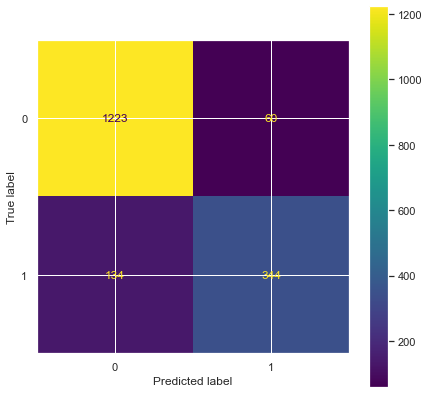

AUC-ROC "площадь под кривой ROC 0.9314


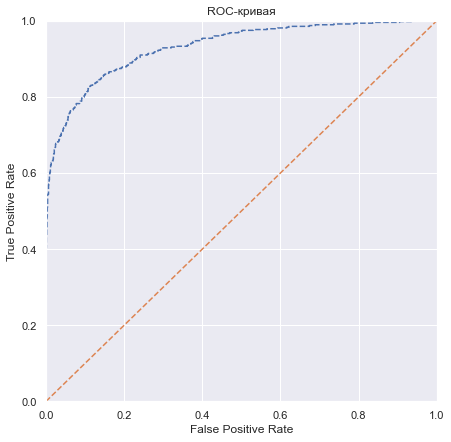

In [147]:
model_metrics_test(model_cb,train_pool,test_pool)

Хороший результат получили целевую метрику ROC_AUC = 0.9314.
У модели довольно хорошие показатели accuracy, precision и recall.
При этом precision выше чем recall, это значит что мы довольно точно будем предсказывать то, что клиент планирует уйти, но при этом не всех клиентов планирующих уйти мы сможем предсказать.

В целом это хорошо, это значит, что в 85% случаях возможные скидки которые компания будет предлагать клиентов не будут даны напрасно.

# 5. Вывод

В ходе проекта, был проведен исследовательский анализ данных, проведена предобработка данных для корректной работы с моделями машинного обучения.

Были протестированы 4 модели: LogRegression, Random Forest, Catboost, LightGBM. По результатам тестирования была выбрана модель Catboost. Которая была проверена на тестовой выборке и показала результат метрики roc_auc=0.9314 который соответствует целевому (roc_auc > 0.85).

Наиболее значимыми признаками оказались продолжительность контракта(сколько дней клиент пользовался услугами на момент снятия данных) а также ежемесячные и суммарные платежи.

Компании имеет смысл собирать обратную связь от клиентов касательно качества предоставляемых услуг и статистику обращений в техническую поддержку, а также проводить опрос о причинах расторжения контракта, эти данные позволят улучшить модель и в целом уменьшить отток абонентов.

Исследовательский анализ наиболее важного признака модели(продолжительность контракта) показал, что большинство клиентов расторгнувшие контракт пользовались услугами провайдера меньше года. То есть много клиентов ушли достаточно быстро, а значит их сразу что-то не устроило. Оператору стоит обратить внимание на работу с новыми клиентами и собирать обратную связь, и действовать на опережение чтобы не допустить оттока.

# 6. Отчет по решению

## 6.1. Соответствие работы с планом
В ходе работы были выполнены все пункты изначального плана:
* Исследовательский анализ данных
* Предобработка и подготовка данных в ходе которой были удалены лишние столбцы, выборка была разбита на обучающую и тестовую в соотношении 3:1, закодированы данные с столбцах (OHE/OrdinalEncoder для категориальных признаков и StandardScaler для числовых) для корректной работы некоторых моделей ML.
* Проведено обучение, подбор гипер-параметров и валидация нескольких моделей ML: Логистическая Регрессия, Случайный лес, и две модели на базе градиентного бустинга CatBoost и LightGBM.
* Проведено тестирование двух лучших моделей на скорость обучения и предсказаний.
* Проведено тестирование финальной модели на тестовой выборке

## 6.2. Трудности возникшие при работе над проектом.

Особых трудностей проект не доставил. Обычная задача на бинарную классификацию.

Был интересный момент связанный с CatBoost. Целевой признак у меня имел тип bool. Оказалось, CatBoost модель имеет небольшой баг, если она была обучена на датасете в формате Pool и с лейблом типа bool, то метод predict() возвращает массив предсказанных целевых признаков в виде True, False, где True/False это <b>строка!!!</b>, типа str, а не bool. Я столкнулся с этим багам уже в самом конце когда строил метрики и графики для тестовой модели с помощью функций из sklearn, когда словил ошибку:

``` TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=[ True] and y_pred=['False' 'True']. Make sure that the predictions provided by the classifier coincides with the true labels. ```


Все встроенные функции Catboost cv(), train() при этом отрабатывают нормально.

Проблема решилась довольно просто: переводом целевого признака из bool в int при создании пула с данными:
то есть вместо pool = Pool(X, y, cat_features=x_cat_col),
pool = Pool(X, y.<b>astype(int)</b>, cat_features=x_cat_col).

Тем не менее надеюсь разработчики исправят этот баг.


Второй нетривиальный момент был срастить LightGBM, Optun'у и подбор параметров на кросс-валидации по целевой метрике auc_roc. Я использовал встроенную функцию пакета lgb.cv(), на выходе она выдает словарь с метриками из которого мне надо было достать единственное значение auc_roc на лучшей итерации бустинга. Решение не очень изящное, я переводил словарь который возвращает lgb.cv() в DF Pandas, и доставал значение метрики методом max() по колонке с auc-roc метрикой.
Возможно именно из-за этого немного "костыльного" решения Optuna не подобрала оптимальные гиперпараметры, и "оптимизированная" модель на кросс-валидации показывала метрики немного хуже чем на дефолтных настройках.

Тем не менее в день написания этого отчета я наткнулся на статью на kaggle [ccылка](https://www.kaggle.com/code/bjoernholzhauer/lightgbm-tuning-with-optuna), и оказалось что в LightGBM есть специальный инструмент lgb.LightGBMTunerCV (интегрированная Optuna) c проверкой метрики на кросс-валидации, поэтому я добавил в проект еще один подход с Optuna и LightGBM. (можно ознакомиться в разделе 3.4) И с этой нативной функцией Optuna отработала хорошо, удалось улучшить метрику на кросс-валидации трейнинг сета по сравнению с дефолтом до 0.909.

## 6.3. Ключевые шаги в решении задачи

* Формирование целевого признака. В исходных данных его не было. Для формирования класса клиента "ушел/не ушел" использовался столбец "End Date" по нему создался столбец с классом, по условию: Если стоит какая то дата в столбцу "End_Date" - 1 (абонент ушел), если даты нет и стоит "No" - 0 (абонент не ушел).

* Второй важной задачей было формирование признака - продолжительность контракта в днях. Этого признака также не было в исходных данных. Для его формирования я сделал замену значений "No" столбца "End Date" на дату снятия данных из базы, таким образом для каждого клиента (и расторгнувшего контракт и действующего) я смог рассчитать продолжительность контракта. При этом важно было затем исключить признаки "End Date" и "Begin Date" так как они несли за собой утечку целевого признака.

* Обе модели градиентного бустинга показали результат значительно превышающий целевое значение >0.85 прямо "из коробки". Однако важным шагом была оптимизация гиперпараметров с помощью инструментов GridSearch (CatBoost) и Optuna (LightGBM) которая позволила повысить метрику на кросс-валидации примерно на 1% в сравнении с дефолтными параметрами моделей.

## 6.4. Предобработка и подготовка признаков

Исходные данные высокого качества, всего с несколькими нюансами:
*Для клиентов, которых подключили в день снятия данных (01.02.2020) был неявный пропуск в виде пробела в столбце "TotalCharges". Я их заменил на 0.
*Даты пришлось переводить в формат datatime для дальнейшей корректной работы с ними
*Данные были разбиты по 4 разным таблицам, однако у всех таблиц был ключ в виде ID абонента, после объединения таблиц по данному ключу образовались пропуски в категориальных признаках, которые я заполнил обычной заглушкой.
*никаких записей с аномальными значениями я не удалял, по причине их отсутствия

Выше уже было описано в рамках задачи был сформирован целевой признак (класс клиента: ушел/не ушел), а также признак - продолжительность контракта ('duration') в днях.

Также, я добавил признак тип сервиса ('service'), он явно не помог в обучении моделей ML так как был избыточным, но я его использовал в EDA, чтобы посмотреть распределение контрактов по типам сервиса (Internet, Phone, Internet+Phone).

Для формирования признаков для обучения моделей ML из исходных данных были удалены только признаки  "End Date", "Begin Date" (несут утечку) и "Customer ID". В целом после корр. анализа, можно было также смело удалить признак "gender", но я не стал этого делать, объем данных небольшой, и признаков тоже немного, на мой взгляд хуже от него модели не будут работать.

Признаки были закодированы двумя методами 1. OHE (кат.)+Standard Scaler(числ) и 2. OrdEnc (кат.) + Standard Scaler (числ)
и сохранены в соответствующих train и test выборках, также сохранены в отдельные переменные признаки без обработки.
При обучении и валидации моделей я использовал следующие варианты кодирования:
* Лог. регрессия - 1. OHE (кат.)+Standard Scaler(числ)
* Random Forest - 2. OrdEnc (кат.) + Standard Scaler
* CatBoost - без кодирования, так как не требуется. модель нативно работает с кат. признаками и не требует нормализации числовых
* LGBM - 2. OrdEnc (кат.) + Standard Scaler модель также нативно работает с кат. признаками но требует чтобы они были в формате чисел, поэтому я использовал Ordinal Encoding.






## 6.5. Итоговая модель
По результатам анализа моделей (метрика на кросс-валидации, скорость работы) была выбрана модель  CatBoost.

В ходе подбора гипераметров GridSearch со следующей сеткой:

|Параметр | Сетка значений|
| --- | --- |
|'depth' | range(2,10,2) |
|'l2_leaf_reg' | np.logspace(-20, -19, 3) |
|'iterations': | [100,500,1000] |
|'learning_rate': | [0.01, 0.05, 0.1] |




были выбраны следующие значения:

| Гипер-параметр | Значение|
| --- | --- |
| depth | 4 |
| iterations | 500 |
| learning_rate | 0.1 |
| l2_leaf_reg | 1e-19 |


Модель была протестирована на тестовой выборке и показала результат выше чем на кросс-валидации (что скорее всего объяснимо тем, что при кросс-валидации у нас обучающая выборка меньшего размера).

Метрики Модели:

| Метрика   | Значение |
|-----------| --- |
| ROC_AUC   | 0.9314 |
| accuracy  | 0.8898 |
| precision | 0.8515 |
| recall    | 0.7197 |
| f1        | 0.78 |

Матрица ошибок:

<img alt="0.png" src="../../../Desktop/Снимок экрана 2023-01-27 в 00.30.48.png"/>

ROC-кривая:

<img alt="1.png" src="../../../Desktop/Снимок экрана 2023-01-27 в 00.32.08.png"/>


Таким образом была достигнута задача по созданию модели, которая предсказывает уход клиента с метрикой auc-roc>0.85.
Также можно обратить внимание что точность(precision) модели почти на 13% выше полноты(recall). Это значит что точность предсказания того что клиент уйдет довольно высокая ~85%, однако модель находит только ~72% клиентов которые хотят уйти.